In [1]:
import gc
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

VER = 3
#Version 2 uses cosine type learning rate scheduler with 10 epochs, CV score 0.75
#Version 1 uses step type LR scheduler with 5 epochs, CV score 0.6227

2024-03-13 13:20:16.697770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 13:20:16.697871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 13:20:16.830400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version = 2.15.0
Using 1 GPU


In this version, we use the weights of the pretrained version 1 of the notebook - trained with step LR scheduler - (which has better CV score than the second version trained with cosine LR scheduler) to perform inference on the test data and make a submission. 

# Load train data and display the spectrogram images

In [2]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]

train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()

In [3]:
spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()
all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

In [4]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score
sys.path.append('/kaggle/input/specs-fr-eegs')
from hms_data_generator import DataGenerator
from spec_eeg import spectrogram_from_eeg

# Build InceptionV3 network

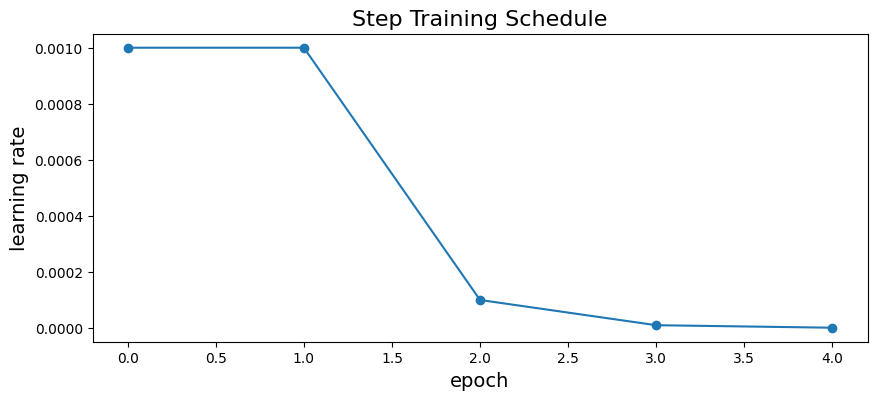

In [5]:
#STEP TYPE
LR_START = 1e-4
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 1
LR_STEP_DECAY = 0.1
EVERY = 1
EPOCHS = 5

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//EVERY)
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Step Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [6]:
#use both Kaggle and eeg spectrograms
USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

In [7]:
def build_model(pretrained_model, WEIGHTS_PATH):
    
    inp = tf.keras.Input(shape=(128,256,8))
    base_model = pretrained_model(include_top=False, weights = None, input_shape=None)
    base_model.load_weights(WEIGHTS_PATH)
   
    # RESHAPE INPUT 128x256x8 => 512x512x3 MONOTONE IMAGE
    # KAGGLE SPECTROGRAMS
    x1 = [inp[:,:,:,i:i+1] for i in range(4)]
    x1 = tf.keras.layers.Concatenate(axis=1)(x1)
    # EEG SPECTROGRAMS
    x2 = [inp[:,:,:,i+4:i+5] for i in range(4)]
    x2 = tf.keras.layers.Concatenate(axis=1)(x2)
    # MAKE 512X512X3
    if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
        x = tf.keras.layers.Concatenate(axis=2)([x1,x2])
    elif USE_EEG_SPECTROGRAMS: x = x2
    else: x = x1
    x = tf.keras.layers.Concatenate(axis=3)([x,x,x])
    
    # OUTPUT
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    #Add a few dense layers in between
    x = tf.keras.layers.Dense(128,activation='ReLU', dtype='float32')(x)
    x = tf.keras.layers.Dense(64,activation='ReLU', dtype='float32')(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
        
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt) 
        
    return model


In [8]:
def apply_trained_model_fold_weights(model_offcial_name, model_name, imagenet_weight_path, trained_weight_path, fold_weights):
    preds = []
    model = build_model(model_offcial_name, imagenet_weight_path)

    for i in range(5):
        print(f'Fold {i+1}')
        model.load_weights(f'{trained_weight_path}{model_name}_f{i}.h5')
        #each pred is 1x6 matrix
        pred = model.predict(test_gen, verbose=1)
        #preds is 5x1x6 tensor
        preds.append(pred)
        
    full_pred = np.average(preds, weights = fold_weights, axis = 0)
           
    return full_pred

In [9]:
#Evaluate trained model on trained data
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

def apply_trained_model_and_score(model_offcial_name,  imagenet_weight_path, trained_weight_path):
    all_oof = []
    all_true = []

    gkf = GroupKFold(n_splits=5)
    for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  

        print('#'*25)
        print(f'### Fold {i+1}')

        train_gen = DataGenerator(train.iloc[train_index],spectrograms, all_eegs, shuffle=True, batch_size=32, augment=False)
        valid_gen = DataGenerator(train.iloc[valid_index], spectrograms, all_eegs,shuffle=False, batch_size=64, mode='valid')

        print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
        print('#'*25)

        K.clear_session()
        with strategy.scope():
            model = build_model(model_offcial_name, imagenet_weight_path)
        if trained_weight_path is None:
            model.fit(train_gen, verbose=1,
                  validation_data = valid_gen,
                    #use cosine type scheduler
                  epochs=EPOCHS, callbacks = [LR])
            model.save_weights(f'InceptionV3_v{VER}_f{i}.h5')
        else:
            model.load_weights(f'{trained_weight_path}InceptionV3_v{VER}_f{i}.h5')

        oof = model.predict(valid_gen, verbose=1)
        all_oof.append(oof)
        all_true.append(train.iloc[valid_index][TARGETS].values)

        del model, oof
        gc.collect()

    all_oof = np.concatenate(all_oof)
    all_true = np.concatenate(all_true)
    
    #calculate KL-Div score for out-of-fold prediction
    oof = pd.DataFrame(all_oof.copy())
    oof['id'] = np.arange(len(oof))
    true = pd.DataFrame(all_true.copy())
    true['id'] = np.arange(len(true))
    cv = score(solution=true, submission=oof, row_id_column_name='id')
    
    return all_oof, all_true, cv

In [10]:
from tensorflow.keras.applications import InceptionV3
#TRAINED_InceptionV3_FROM = '/kaggle/input/hms-mobilenetv2-trained-weights/'
TRAINED_InceptionV3_FROM = None
WEIGHTS_PATH_Inc  = '/kaggle/input/pretrained-imagenet-weights-for-various-networks/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [11]:
oof_I, true_I, cvI = apply_trained_model_and_score(InceptionV3,  WEIGHTS_PATH_Inc, TRAINED_InceptionV3_FROM)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


I0000 00:00:1710336209.303863      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


428/428 [==============================] - 373s 744ms/step - loss: 0.8645 - val_loss: 2.3104 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
428/428 [==============================] - 298s 696ms/step - loss: 0.6852 - val_loss: 1.1251 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
428/428 [==============================] - 297s 694ms/step - loss: 0.5376 - val_loss: 0.7409 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5
428/428 [==============================] - 297s 693ms/step - loss: 0.4946 - val_loss: 0.7164 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5
54/54 [==============================] - 22s 377ms/step
#########################
### Fold 2
### train size 13671, valid size 3418
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5
428/42

In [12]:
cvI

0.6721237691432267

# Load test data

In [13]:
#test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')

In [14]:
# READ ALL SPECTROGRAMS
#PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
#files2 = os.listdir(PATH2)
#print(f'There are {len(files2)} test spectrogram parquets')
    
#spectrograms2 = {}
#for i,f in enumerate(files2):
#    if i%100==0: print(i,', ',end='')
#    tmp = pd.read_parquet(f'{PATH2}{f}')
#    name = int(f.split('.')[0])
#    spectrograms2[name] = tmp.iloc[:,1:].values
    
# RENAME FOR DATALOADER
#test = test.rename({'spectrogram_id':'spec_id'},axis=1)

In [15]:
# READ ALL EEG SPECTROGRAMS
#PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
#DISPLAY = 1
#EEG_IDS2 = test.eeg_id.unique()
#all_eegs2 = {}

#print('Converting Test EEG to Spectrograms...'); print()
#for i,eeg_id in enumerate(EEG_IDS2):        
    # CREATE SPECTROGRAM FROM EEG PARQUET
  #  img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', eeg_id, i<DISPLAY)
  #  all_eegs2[eeg_id] = img

In [16]:
#Load test data in the final format
#test_gen = DataGenerator(test, spectrograms2, all_eegs2, shuffle=False, batch_size=64, mode='test',)

In [17]:
# Determine fold weights
# Fold 1: val_loss: 0.6436
# Fold 2:  val_loss 0.5849
# Fold 3: val_loss: 0.5629
# Fold 4: val_loss: 0.6413
# Fold 5: val_loss: 0.6810

#fold_weight = [0.15, 0.25, 0.3, 0.15, 0.15]
#np.sum(fold_weight)

In [18]:
#pred_M4 = apply_trained_model_fold_weights(InceptionV3, Inc_name, WEIGHTS_PATH_Inc, TRAINED_InceptionV3_FROM, fold_weight)

In [19]:
#np.sum(pred_M4)

# Submission

In [20]:
#submission = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")
#labels = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']

# Assign model predictions to respective columns in the submission DataFrame
#for i in range(len(labels)):
#    submission[f'{labels[i]}_vote'] = pred_M4[:, i]
# Save the updated DataFrame as the final submission file
#submission.to_csv("submission.csv", index=None)

In [21]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
#submission.iloc[:,-6:].sum(axis=1)